# Analyzing snATAC-seq data of human colon samples

In [2]:
import snapatac2 as snap
import anndata as ad
from os import listdir
import numpy as np

In [3]:
files = listdir("data")

In [4]:
files

['colon_transverse_SM-BZ2ZS_rep1_fragments.bed.gz',
 'colon_transverse_SM-A9VP4_rep1_fragments.bed.gz',
 'colon_transverse_SM-ACCQ1_rep1_fragments.bed.gz',
 'colon_transverse_SM-CSSDA_rep1_fragments.bed.gz',
 'colon_transverse_SM-A9HOW_rep1_fragments.bed.gz']

In [5]:
datasets = {}
for fl in files:
    print(fl)
    name = fl.split("_rep1_fragments")[0]
    
    # Compute QC metric and cell by 500bp-bin matrix
    data = snap.make_tile_matrix(name + "_raw.h5ad",
        "data/" + fl,
        "/projects/ps-renlab/kai/genome/GRCh38/gencode.v33.basic.annotation.gtf",
        snap.hg38)
    
    # Select cells based on number of unique fragments and TSS enrichment scores
    selected_cells = np.logical_and(data.obs["n_fragment"] >= 1000, data.obs["tsse"] >= 7)
    data = data[selected_cells, :]
    
    # Save filtered data to a different file
    data.copy(filename = name + "_filtered.h5ad")
    datasets[name] = data


colon_transverse_SM-BZ2ZS_rep1_fragments.bed.gz
colon_transverse_SM-A9VP4_rep1_fragments.bed.gz
colon_transverse_SM-ACCQ1_rep1_fragments.bed.gz
colon_transverse_SM-CSSDA_rep1_fragments.bed.gz
colon_transverse_SM-A9HOW_rep1_fragments.bed.gz


In [6]:
datasets

{'colon_transverse_SM-BZ2ZS': View of AnnData object with n_obs × n_vars = 6174 × 6176550 backed at 'colon_transverse_SM-BZ2ZS_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'colon_transverse_SM-A9VP4': View of AnnData object with n_obs × n_vars = 2438 × 6176550 backed at 'colon_transverse_SM-A9VP4_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'colon_transverse_SM-ACCQ1': View of AnnData object with n_obs × n_vars = 1332 × 6176550 backed at 'colon_transverse_SM-ACCQ1_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'colon_transverse_SM-CSSDA': View of AnnData object with n_obs × n_vars = 7511 × 6176550 backed at 'colon_transverse_SM-CSSDA_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'colon_transverse_SM-A9HOW': View of AnnData object with n_obs × n_vars = 7512 × 6176550 backed at 'colon_transverse_SM-A9HOW_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'}

In [15]:
# Merge all data. The resultant object stores references to individual data.
# Data will not be copied but remain on the disk
data = ad.experimental.AnnCollection(
    datasets,
    index_unique = "_",
    join_obsm="inner",
    label="batch"
)
data

AnnCollection object with n_obs × n_vars = 24967 × 6176550
  constructed from 5 AnnData objects
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'batch'

In [17]:
# Feature selection
features = snap.find_variable_features(data)

In [18]:
# Perform dimension reduction. The result is stored in `data.obsm["X_spectral"]
snap.spectral(data, features=features, sample_size=10000, chunk_size=5000)

Compute similarity matrix
Perform read-depth correction
Normalizing jaccard similarity
Normalization
Reduction


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.96s/it]


In [19]:
# Perform UMAP
snap.umap(data)

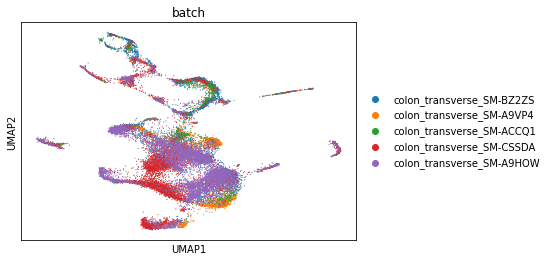

In [20]:
import scanpy as sc
sc.pl.umap(data.to_adata(), color="batch")

In [ ]:
# Save the result to file
data.to_adata().write("out.h5ad")

In [13]:
data

AnnCollection object with n_obs × n_vars = 24967 × 6176550
  constructed from 5 AnnData objects
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    obsm: 'X_spectral', 'X_umap'

In [16]:
data.obs

,tsse,n_fragment,frac_dup,frac_mito,batch
Cell,,,,,
AACGAGAGCTAACGACTGCTCG_colon_transverse_SM-BZ2ZS,12.197929,4025,0.439493,0.007205,colon_transverse_SM-BZ2ZS
AACGAGAGCTAACTGATAGGAG_colon_transverse_SM-BZ2ZS,8.791209,2228,0.446735,0.019300,colon_transverse_SM-BZ2ZS
AACGAGAGCTAAGCCCATTGCC_colon_transverse_SM-BZ2ZS,10.935441,3337,0.431129,0.022775,colon_transverse_SM-BZ2ZS
AACGAGAGCTAAGCGGAACCTA_colon_transverse_SM-BZ2ZS,7.649667,2933,0.438982,0.023184,colon_transverse_SM-BZ2ZS
AACGAGAGCTAAGTAGCCCGCT_colon_transverse_SM-BZ2ZS,7.624633,1571,0.462538,0.029917,colon_transverse_SM-BZ2ZS
...,...,...,...,...,...
TTTCTGTCGGTTCGGTTCCCAC_colon_transverse_SM-A9HOW,21.982537,3044,0.417416,0.010512,colon_transverse_SM-A9HOW
TTTCTGTCGGTTGTCATGCGTG_colon_transverse_SM-A9HOW,8.668968,4417,0.379722,0.035997,colon_transverse_SM-A9HOW
TTTCTGTCGGTTTACCCGTCGA_colon_transverse_SM-A9HOW,8.093842,2881,0.387933,0.017355,colon_transverse_SM-A9HOW
